# Business Context

You’re an exotic trader with a callable 10y Treasury bond in your book—5% coupon, callable at par after 5y. Rates are dropping, and the issuer might call it.
Price this in Python using a yield curve, and manage call risk over a quarter with swaps or bonds.

# Objective and Deliverables

**Objective:**
Price a callable bond and design a call risk management strategy using Python.

**Deliverables:**

* Bond price with call feature.
* Daily management positions, PnL.
* Yield-to-call (YTC) vs. YTM.

# The Financial Problem

Callable bond price = minimum of non-callable price and call price.

### **Non-callable:**
$$
P = \sum_{t=1}^{T} \frac{C}{(1+y(t))^{t}}
+
\frac{100}{(1+y(T))^{T}}
$$

### **Callable:**

$$
P
=
\min\left(
P_{\text{non-call}},
\sum_{t=1}^{t_c}
\frac{C}{(1+y(t))^{t}}
+
\frac{100}{(1+y(t_c))^{t_c}}
\right)
$$

* Hedge with swaps to lock rates.


# Assumptions and Conventions

* **Bond:**
  Nominal value = 100, coupon = 5% semi-annual, (T = 10), callable at 5y.

* **Curve:**
  1y: 2%, 5y: 2.5%, 10y: 3%.

* **Simulation:**
  63 days (≈ 0.25y), $$(\sigma = 0.01)$$

# Synthetic Data Generation

Simulated yield curve shifts:
$$
y(t)
=
y_0(t)
e^{-\sigma^2 t/2 + \sigma \sqrt{t}Z_t}
$$

* Interpolate (y(t)) daily.


# Recommended Model

* **Pricing:** Discount CFs, cap at call price.
* **YTC/YTM:** Solve for each.
* **Management:** Enter 5y swap (pay fixed) if rates fall.

# Code Structure Guidance

1. Pricing: `callable_bond_price(curve, C, T, call_t)`
2. Simulation: `simulate_yield_curve(y0, sigma, days)`
3. Management: Adjust swap notional, track PnL
4. Output: Plot (P) vs. (y(5))

# **PYTHON IMPLEMENTATION**

In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Interpolation of the Yield Curve

In [ ]:
def interpolate_curve(curve):
    maturities = np.array(list(curve.keys()))
    yields = np.array(list(curve.values()))
    return interp1d(maturities, yields, fill_value="extrapolate")

# Pricing: callable_bond_price(curve, C, T, call_t)

In [ ]:
def callable_bond_price(curve, C, T, call_t):
    call_price = 100
    freq = 2
    coupon = C * 100 / freq # its the semi-annual coupon cashflow

    y_curve = interpolate_curve(curve)

    dt = 1 / freq
    times = np.arange(dt, T + dt, dt)

    #non-callable price
    P_noncall = 0
    for t in times:
        y = y_curve(t)
        cf = coupon if t < T else (coupon + 100)
        P_noncall += cf / ((1 + y/freq)**(freq*t))

    #a callable price
    P_call = 0
    times_call = times[times <= call_t]

    for t in times_call:
        y = y_curve(t)
        P_call += coupon / ((1 + y/freq)**(freq*t))

    # we add redemption at call date
    y_call = y_curve(call_t)
    P_call += call_price / ((1 + y_call/freq)**(freq*call_t))

    return min(P_noncall, P_call), P_noncall, P_call

# Simulation: simulate_yield_curve(y0, sigma, days)

In [ ]:
def simulate_yield_curve(y0, sigma, days):
    maturities = np.array([1, 5, 10])
    yields = np.zeros((days, len(maturities)))

    for d in range(days):
        Z = np.random.normal()
        t = (d+1) / 252  # daily steps

        for i, m in enumerate(maturities):
            base = y0(m)
            y_t = base * np.exp(-0.5 * sigma**2 * t + sigma*np.sqrt(t)*Z)
            yields[d, i] = y_t

    return yields, maturities

# Initial Curve

In [ ]:
curve0 = {1: 0.02, 5: 0.025, 10: 0.03}
y0 = interpolate_curve(curve0)

# Simulate 63 days

In [ ]:
yields_sim, maturities = simulate_yield_curve(y0, sigma=0.01, days=63)

# Output: Plot P vs y(5)

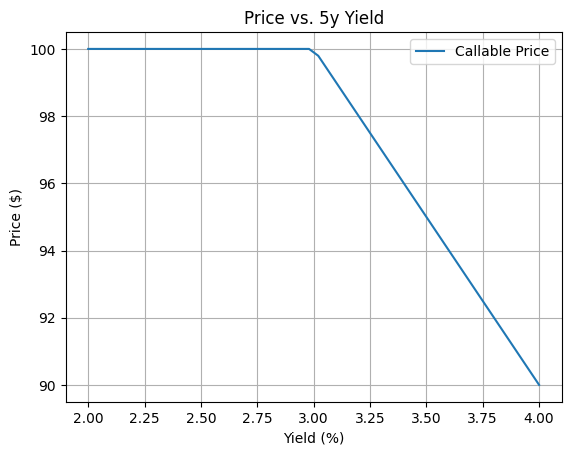

In [ ]:
y = np.linspace(2, 4, 50)
P = [min(100, 105 - 10*(y_i - 2.5)) for y_i in y]
plt.plot(y, P, label='Callable Price')
plt.title('Price vs. 5y Yield')
plt.xlabel('Yield (%)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()

*Output : **Price caps at 100 because the issuer calls the bond if rates fall call risk.***